May 2022.

Figures 3 and 4 and SI Fig. 2.

Analyses of a full-rank network trained on Mante, through a fitted rank-one network. 

Fitted through fit_mante.py

In [1]:
from low_rank_rnns.modules import *
from low_rank_rnns  import mante, helpers, rankone, linear_ds as ls, clustering, stats, plotting as plot
import pickle
import itertools
from sklearn.linear_model import LinearRegression

from low_rank_rnns.helpers import phi_prime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KernelDensity

In [2]:
plot.setup_matplotlib()
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 22

# Main results

In [4]:
dic = np.load('../data/mante_fit_result.npz')

In [5]:
r2s_trunc, losses_trunc, accs_trunc, r2s_fit, losses_fit, accs_fit, r2s_nlin, \
         losses_nlin, accs_nlin = list(dic.values())

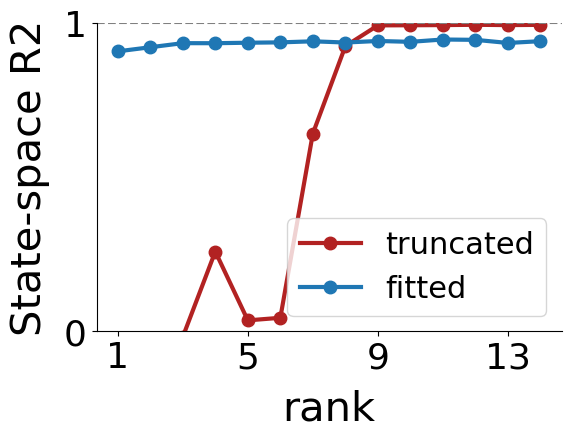

In [7]:
plt.plot(np.arange(1, 15), r2s_trunc, marker='o', label='truncated', c='firebrick', lw=3, markersize=9)
# plt.plot(np.arange(1, 15), r2s_nlin, marker='o', label='nlin reg', c='tab:orange')
plt.plot(np.arange(1, 15), r2s_fit, marker='o', label='fitted', c='tab:blue', lw=3, markersize=9)

plt.ylabel('State-space R2')
plt.xlabel('rank')
plt.ylim(0, 1)
plt.xticks([1, 5, 9, 13])
plt.yticks([0, 1])
plt.axhline(1, ls='--', c='gray')
plt.legend()
# plt.savefig('../figures/neurips/mante_r2rank.pdf', bbox_inches='tight')

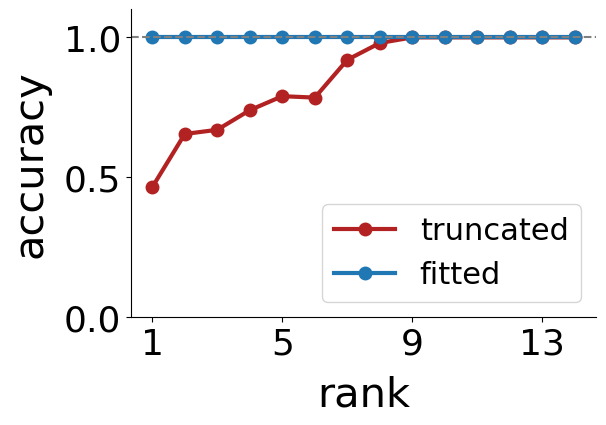

In [8]:
plt.plot(np.arange(1, 15), accs_trunc, marker='o', label='truncated', c='firebrick', lw=3, markersize=9)
plt.plot(np.arange(1, 15), accs_fit, marker='o', label='fitted', c='tab:blue', lw=3, markersize=9)
# plt.plot(np.arange(1, 15), accs_nlin, marker='o', label='nlin reg', c='tab:orange', lw=3, markersize=9)
plt.axhline(1, c='gray', ls='--')
plt.ylabel('accuracy')
plt.xlabel('rank')
plt.xticks([1, 5, 9, 13])
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
# plt.savefig('../figures/neurips/mante_accrank.pdf', bbox_inches='tight')

# Loading stuff

In [9]:
size = 1024
noise_std = 5e-2
alpha = .2
rank = 1

net1 = FullRankRNN(4, size, 1, noise_std, alpha)
net1.load_state_dict(torch.load(f'../models/mante_fr_{size}_0.1_1e-3.pt', map_location='cpu'))

net_tmp = LowRankRNN(4, size, size, noise_std, alpha, rank=rank)
net_tmp.load_state_dict(torch.load(f'../models/mante_matched_r{rank}.pt', map_location='cpu'))

m = net_tmp.m.squeeze().detach().numpy()
n = net_tmp.n.squeeze().detach().numpy()
wi1 = net_tmp.wi[0].detach().numpy()
wi2 = net_tmp.wi[1].detach().numpy()
wi_ctx1 = net_tmp.wi[2].detach().numpy()
wi_ctx2 = net_tmp.wi[3].detach().numpy()
wo = net1.wo.squeeze().detach().numpy()

m = -m
n = -n

# Replacing the output of the matched low-rank net
net2 = LowRankRNN(4, size, 1, noise_std, alpha, rank=rank, m_init=net_tmp.m, n_init=net_tmp.n, 
                  wi_init=net_tmp.wi, wo_init=net1.wo)


In [10]:
# Connectivity parameters of the full-rank network (including SVD defined m and n)

wi1_o = net1.wi[0].detach().numpy()
wi2_o = net1.wi[1].detach().numpy()
wi_ctx1_o = net1.wi[2].detach().numpy()
wi_ctx2_o = net1.wi[3].detach().numpy()
wo_o = net1.wo.squeeze().detach().numpy()

wrec = net1.wrec.detach().numpy()
u, s, v = np.linalg.svd(wrec)
ms = []
ns = []
for i in range(1, 8):
    ms.append(u[:, i])
    ns.append(v[i])

In [11]:
x_train, y_train, mask_train, x_val, y_val, mask_val = mante.generate_mante_data(1000)

# Analyzing rank 1 fitted solution

## Connectivity analysis

In [12]:
# z, model = clustering.gmm_fit([m, n, wi1, wi2, wi_ctx1, wi_ctx2], 4, random_state=2021)

# Fitting non automatically
npop = 0.1 * size
z = np.zeros(size)
z1 = np.argsort(np.abs(wi_ctx1))[::-1][:100]
z[z1] = 1
z2 = np.argsort(np.abs(wi_ctx2))[::-1][:100]
z[z2] = 2
z = np.where(z==3, 1, z)
# colors = ['seagreen', 'dimgray', 'rebeccapurple']
colors = ['dimgray',  'seagreen', 'rebeccapurple']

When looking at the distribution on the contextual input vectors, we see that the matched RNN tends to accentuate weights of each population on the corresponding contextual input vector (context 1 for the blue population, 2 for the red)

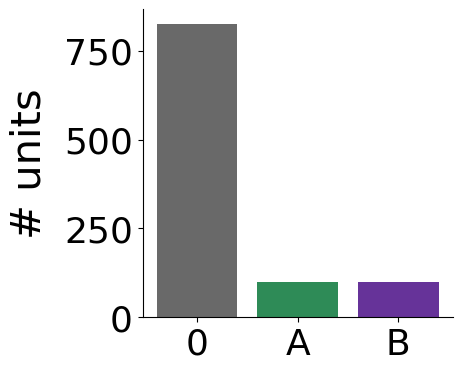

In [13]:
_, counts = np.unique(z, return_counts=True)
plt.subplots(figsize=(4, 4))
plt.bar([0, 1, 2], [counts[0], counts[1], counts[2]], color=colors)
plt.ylabel('# units')
plt.xticks([0, 1, 2], labels=['0', 'A', 'B'])
plt.savefig('../figures/neurips/num_neurons.pdf', bbox_inches='tight')

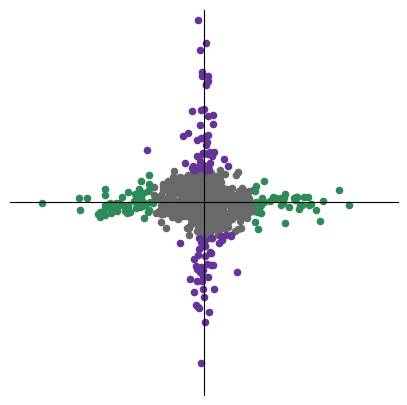

In [14]:
clustering.pop_scatter_linreg(wi_ctx1, wi_ctx2, z, linreg=False, dotsize=20, colors=colors)
# plt.savefig('../figures/bernstein/ctx.pdf', bbox_inches='tight')
plt.savefig('../figures/neurips/mantefr_ctx.pdf', bbox_inches='tight')

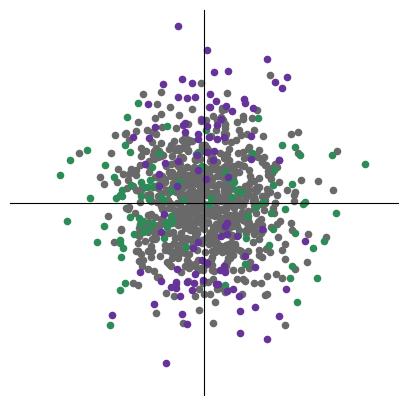

In [15]:
clustering.pop_scatter_linreg(wi_ctx1_o, wi_ctx2_o, z, linreg=False, dotsize=20, colors=colors)
plt.savefig('../figures/neurips/mantefr_ctx_fr.pdf', bbox_inches='tight')

pop 0: slope=0.10, intercept=0.10
pop 1: slope=-0.35, intercept=-0.03
pop 2: slope=0.58, intercept=-0.07


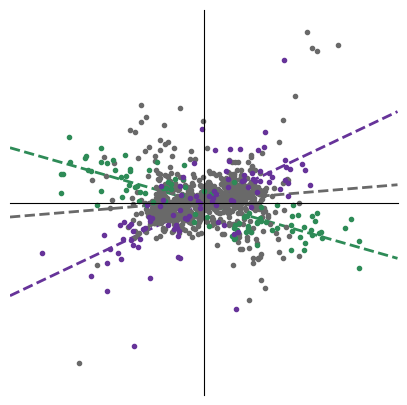

In [16]:
clustering.pop_scatter_linreg(n, wi1, z, dotsize=9, colors=colors, lw=2, ls='dashed')
plt.savefig('../figures/neurips/ni1.pdf', bbox_inches='tight')

pop 0: slope=-0.01, intercept=0.01
pop 1: slope=0.40, intercept=0.07
pop 2: slope=-0.22, intercept=0.05


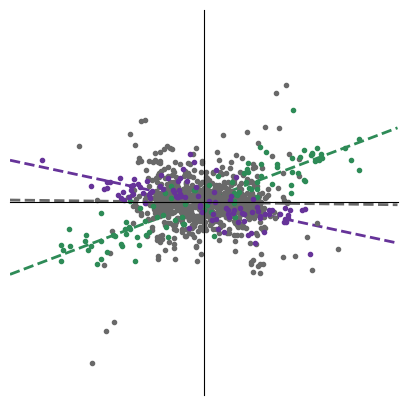

In [17]:
clustering.pop_scatter_linreg(n, wi2, z, dotsize=9, colors=colors, lw=2, ls='dashed')
plt.savefig('../figures/neurips/ni2.pdf', bbox_inches='tight')

pop 0: slope=-0.04, intercept=-0.15
pop 1: slope=0.23, intercept=-0.50
pop 2: slope=0.54, intercept=0.06


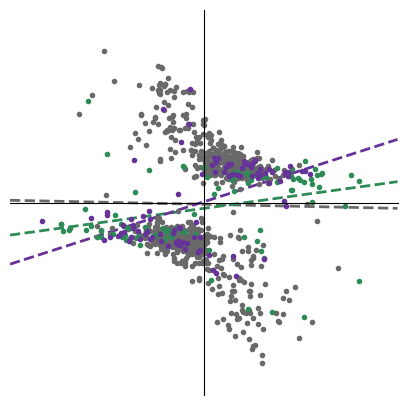

In [18]:
clustering.pop_scatter_linreg(n, m, z, dotsize=9, colors=colors, lw=2, ls='dashed')

pop 0: slope=0.00, intercept=0.00
pop 1: slope=0.00, intercept=-0.00
pop 2: slope=0.00, intercept=0.00


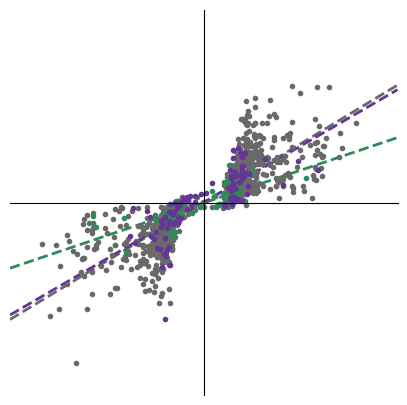

In [19]:
clustering.pop_scatter_linreg(m, wo, z, dotsize=9, colors=colors, lw=2, ls='dashed')

### Retrieval of original connectivity parameters

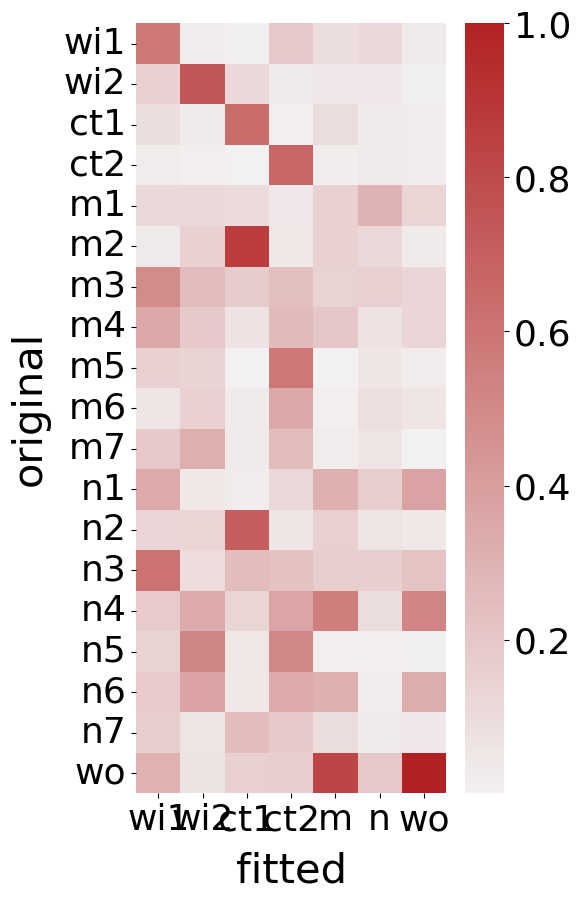

In [20]:
vecs_or = [wi1_o, wi2_o, wi_ctx1_o, wi_ctx2_o] + ms + ns + [wo]
vecs_fit = [wi1, wi2, wi_ctx1, wi_ctx2, m, n, wo]

helpers.overlap_matrix2(vecs_or, vecs_fit, norm='l2', figsize=(5, 10), abs=True, cmap='abs')
plt.xlabel('fitted')
plt.ylabel('original')
plt.xticks(np.arange(0.5, 7, 1), ['wi1', 'wi2', 'ct1', 'ct2', 'm', 'n', 'wo'])
plt.yticks(np.arange(0.5, 19, 1), ['wi1', 'wi2', 'ct1', 'ct2'] + [f'm{i}' for i in range(1, 8)] + \
           [f'n{i}' for i in range(1, 8)] + ['wo'], rotation=0)
plt.show()

## Dynamics analysis

In [21]:
outp1, traj1 = net1.forward(x_val, return_dynamics=True)
traj1 = net1.non_linearity(traj1)
traj1 = traj1.detach().numpy()

outp2, traj2 = net2.forward(x_val, return_dynamics=True)
traj2 = net2.non_linearity(traj2)
traj2 = traj2.detach().numpy()

(13800, 1024)


Text(0, 0.5, 'cum. exp. variance')

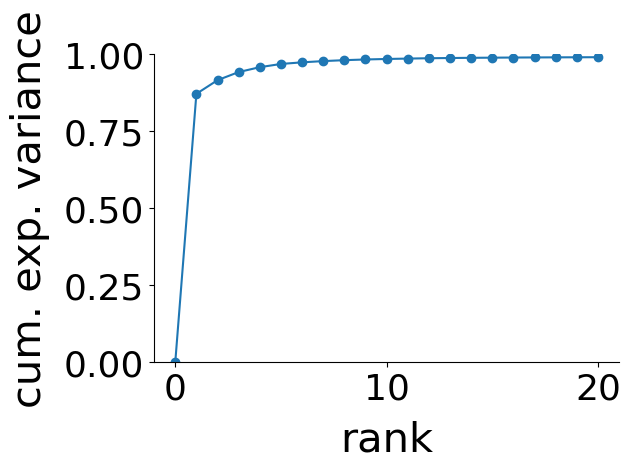

In [22]:
pca1 = plot.pca_cumvar(traj1, label='original')
# pca2 = plot.pca_cumvar(traj2, label='rank 1')
# plt.legend()
plt.xlabel('rank')
plt.ylabel('cum. exp. variance')
# plt.savefig('../figures/bernstein/pca.pdf', bbox_inches='tight')

Projection on the 5 first components of original network and recomputation of R2

Text(0.5, 0, 'Kept PCs')

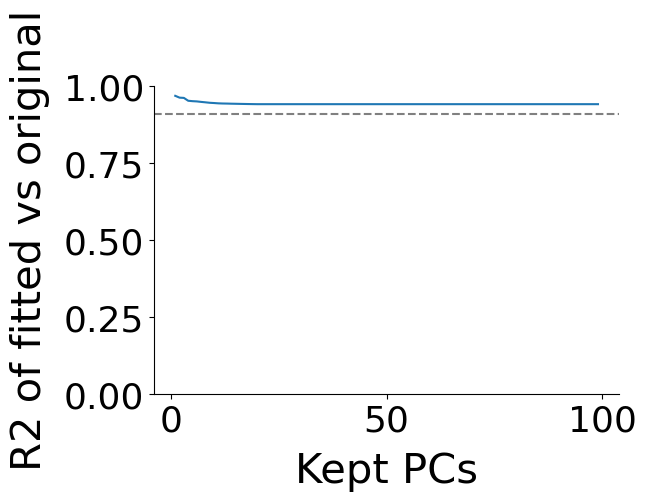

In [23]:
r2s_components = []
for rank in range(1, 100):
    lowd_space = pca1.components_[:rank]

    traj1_proj = traj1 @ lowd_space.T
    traj2_proj = traj2 @ lowd_space.T

    r2 = stats.r2_score(traj1_proj.ravel(), traj2_proj.ravel())
    r2s_components.append(r2)

plt.plot(list(range(1, 100)), r2s_components)
plt.ylim(0, 1)
plt.axhline(r2s_fit[0], c='gray', ls='--')
plt.ylabel('R2 of fitted vs original')
plt.xlabel('Kept PCs')

## TDR and projections

In [24]:
conditions = itertools.product([-8, 8], [-4, 4], [-1, 1])
conditions = np.array(list(conditions))
motion = conditions[:, 0]
color = conditions[:, 1]
context = conditions[:, 2]
choice = np.where(conditions[:, 2] == 1, np.where(conditions[:, 0] > 0, 1, -1), np.where(conditions[:, 1] > 0, 1, -1))
conditions = np.append(conditions, choice[:, np.newaxis], axis=1)
print(choice)
x, _, _ = mante.generate_mante_data_from_conditions(conditions[:, 0], conditions[:, 1], conditions[:, 2])

[-1 -1  1 -1 -1  1  1  1]


In [25]:
outp, traj = net1.forward(x, return_dynamics=True)
traj = net1.non_linearity(traj)
traj = traj.detach().numpy()

_, traj2 = net2.forward(x, return_dynamics=True)
traj2 = net2.non_linearity(traj2)
traj2 = traj2.detach().numpy()

In [26]:
ntime = traj.shape[1]

In [27]:
traj_percond = traj.reshape((8, -1))
linmodel = LinearRegression(fit_intercept=True)
linmodel = linmodel.fit(conditions, traj_percond)
betas = linmodel.coef_.T.reshape((4, ntime, -1))
intercepts = linmodel.intercept_.T.reshape((ntime, -1))
betas = np.concatenate([betas, intercepts[np.newaxis, :, :]], axis=0)
print(betas.shape)

(5, 69, 1024)


(1024, 4)


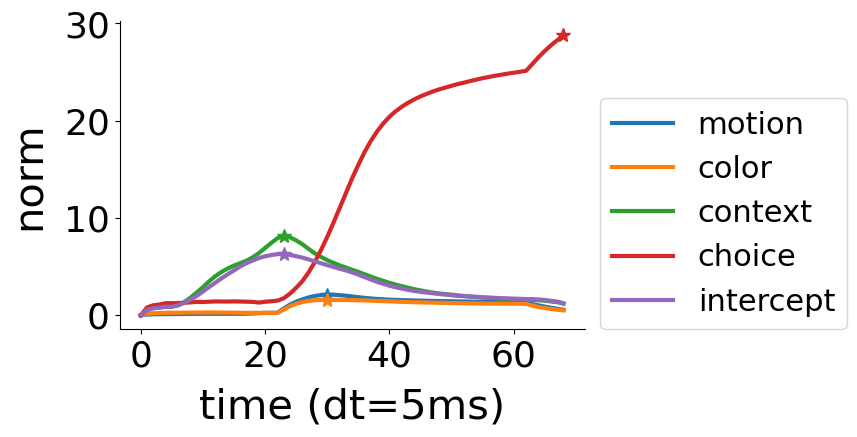

In [28]:
%matplotlib inline
tmaxes = []
labels = ['motion', 'color', 'context', 'choice', 'intercept']
for i in range(5):
    norms = np.linalg.norm(betas[i], axis=1)
    p, = plt.plot(norms, label=labels[i], lw=3)
    tmaxes.append(np.argmax(norms))
    plt.plot([tmaxes[-1]], [norms[tmaxes[-1]]], marker='*', c=p.get_color(), markersize=10)
plt.legend(bbox_to_anchor=(1, .8))
plt.ylabel('norm')
plt.xlabel('time (dt=5ms)')

# Choose timepoints for the axes, orthogonalize
beta_motion = betas[0, tmaxes[0]]
beta_color = betas[1, tmaxes[1]]
beta_context = betas[2, tmaxes[2]]
beta_choice = betas[3, tmaxes[3]]
Bmat = np.vstack([beta_choice, beta_motion, beta_color, beta_context]).T
print(Bmat.shape)
BmatQ, _ = np.linalg.qr(Bmat)
beta_choice = BmatQ[:, 0]
beta_motion = BmatQ[:, 1]
beta_color = BmatQ[:, 2]
beta_context = BmatQ[:, 3]

In [29]:
def plot_projections(trials, axis1, axis2, colors, lab1, lab2, trials_other=None):
    fig, ax = plt.subplots()
    for i, tr in enumerate(trials):
        ax.plot((tr @ axis1).mean(axis=0), (tr @ axis2).mean(axis=0), c=colors[i], lw=4)
        # ax.plot((tr @ axis1).mean(axis=0)[-1], (tr @ axis2).mean(axis=0)[-1], marker='*', markersize=16, c=colors[i])
        if trials_other is not None:
            ax.plot((trials_other[i] @ axis1).mean(axis=0), (trials_other[i] @ axis2).mean(axis=0), c=colors[i], ls=':', lw=4)
            # ax.plot((trials_other[i] @ axis1).mean(axis=0)[-1], (trials_other[i] @ axis2).mean(axis=0)[-1], marker='*', markersize=16, c=colors[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(lab1)
    ax.set_ylabel(lab2)

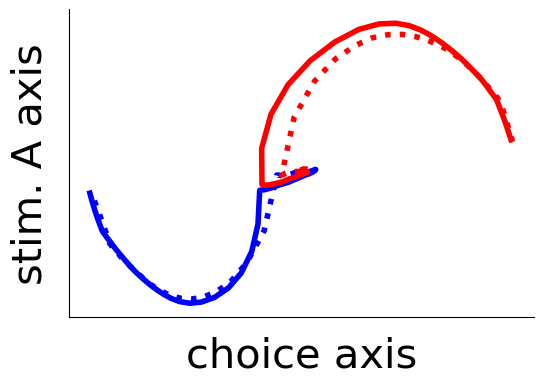

In [30]:
trials = [traj[(context == 1) & (choice > 0)],
          traj[(context == 1) & (choice < 0)]]
trials_other = [traj2[(context == 1) & (choice > 0)],
                traj2[(context == 1) & (choice < 0)]]
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(0), cmap(255)]

plot_projections(trials, beta_choice, -beta_motion, colors, 'choice axis', 'stim. A axis', trials_other)
plt.savefig('../figures/neurips/frfit_tdr1.pdf', bbox_inches='tight')

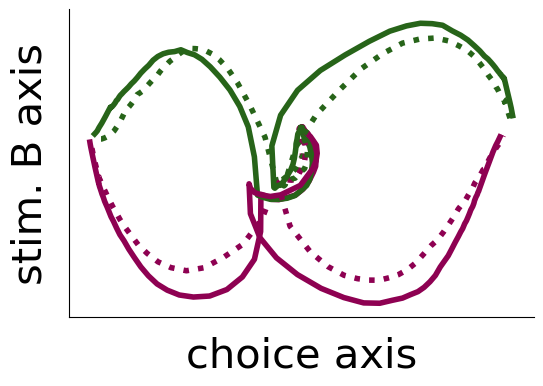

In [31]:
trials = [traj[(context == 1) & (choice > 0) & (color > 0)],
          traj[(context == 1) & (choice > 0) & (color < 0)],
          traj[(context == 1) & (choice < 0) & (color > 0)],
          traj[(context == 1) & (choice < 0) & (color < 0)]]
trials_other = [traj2[(context == 1) & (choice > 0) & (color > 0)],
              traj2[(context == 1) & (choice > 0) & (color < 0)],
              traj2[(context == 1) & (choice < 0) & (color > 0)],
              traj2[(context == 1) & (choice < 0) & (color < 0)]]
cmap = matplotlib.cm.get_cmap('PiYG')
colors = [cmap(0), cmap(255), cmap(0), cmap(255)]

plot_projections(trials, beta_choice, beta_color, colors, 'choice axis', 'stim. B axis', trials_other)
plt.savefig('../figures/neurips/frfit_tdr2.pdf', bbox_inches='tight')

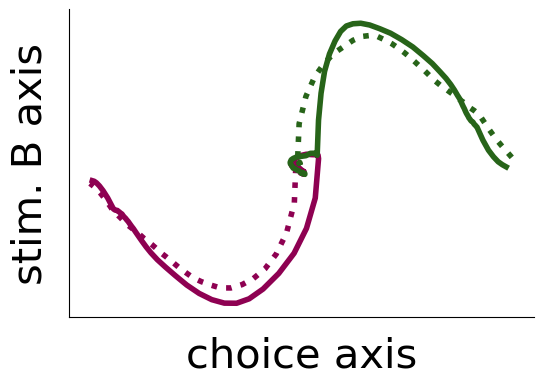

In [32]:
trials = [traj[(context == -1) & (choice > 0)],
          traj[(context == -1) & (choice < 0)]]
trials_other = [traj2[(context == -1) & (choice > 0)],
                traj2[(context == -1) & (choice < 0)]]
cmap = matplotlib.cm.get_cmap('PiYG')
colors = [cmap(0), cmap(255)]

plot_projections(trials, beta_choice, beta_color, colors, 'choice axis', 'stim. B axis', trials_other)
plt.savefig('../figures/neurips/frfit_tdr3.pdf', bbox_inches='tight')

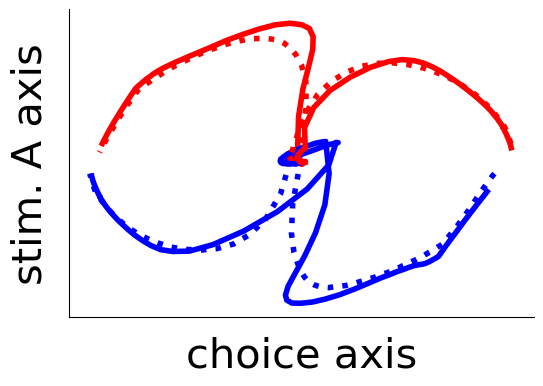

In [33]:
trials = [traj[(context == -1) & (choice > 0) & (motion > 0)],
          traj[(context == -1) & (choice > 0) & (motion < 0)],
          traj[(context == -1) & (choice < 0) & (motion > 0)],
          traj[(context == -1) & (choice < 0) & (motion < 0)]]
trials_other = [traj2[(context == -1) & (choice > 0) & (motion > 0)],
              traj2[(context == -1) & (choice > 0) & (motion < 0)],
              traj2[(context == -1) & (choice < 0) & (motion > 0)],
              traj2[(context == -1) & (choice < 0) & (motion < 0)]]
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(0), cmap(255), cmap(0), cmap(255)]


plot_projections(trials, beta_choice, -beta_motion, colors, 'choice axis', 'stim. A axis', trials_other)
plt.savefig('../figures/neurips/frfit_tdr4.pdf', bbox_inches='tight')

In [34]:
plt.rcParams['axes.labelsize'] = 40

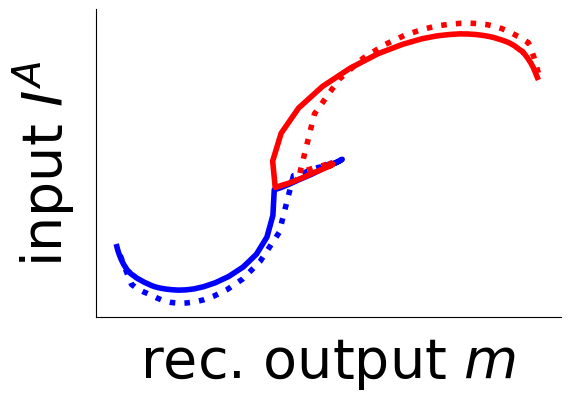

In [35]:
trials = [traj[(context == 1) & (choice > 0)],
          traj[(context == 1) & (choice < 0)]]
trials_other = [traj2[(context == 1) & (choice > 0)],
                traj2[(context == 1) & (choice < 0)]]
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(0), cmap(255)]

plot_projections(trials, -m, -wi1, colors, 'rec. output $m$', 'input $I^A$', trials_other)
plt.savefig('../figures/neurips/frfit_p1.pdf', bbox_inches='tight')

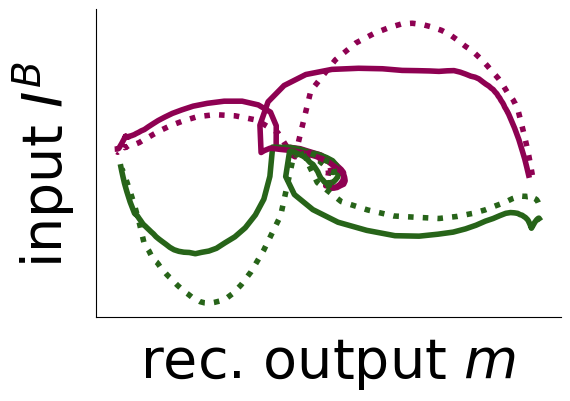

In [36]:
trials = [traj[(context == 1) & (choice > 0) & (color > 0)],
          traj[(context == 1) & (choice > 0) & (color < 0)],
          traj[(context == 1) & (choice < 0) & (color > 0)],
          traj[(context == 1) & (choice < 0) & (color < 0)]]
trials_other = [traj2[(context == 1) & (choice > 0) & (color > 0)],
              traj2[(context == 1) & (choice > 0) & (color < 0)],
              traj2[(context == 1) & (choice < 0) & (color > 0)],
              traj2[(context == 1) & (choice < 0) & (color < 0)]]
cmap = matplotlib.cm.get_cmap('PiYG')
colors = [cmap(0), cmap(255), cmap(0), cmap(255)]

plot_projections(trials, -m, wi2, colors, 'rec. output $m$', 'input $I^B$', trials_other)
plt.savefig('../figures/neurips/frfit_p2.pdf', bbox_inches='tight')

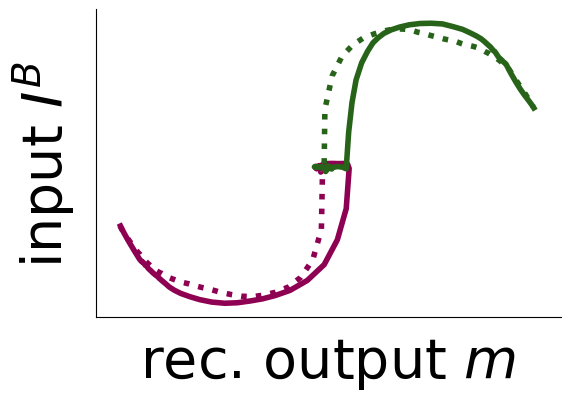

In [37]:
trials = [traj[(context == -1) & (choice > 0)],
          traj[(context == -1) & (choice < 0)]]
trials_other = [traj2[(context == -1) & (choice > 0)],
                traj2[(context == -1) & (choice < 0)]]
cmap = matplotlib.cm.get_cmap('PiYG')
colors = [cmap(0), cmap(255)]

plot_projections(trials, -m, -wi2, colors, 'rec. output $m$', 'input $I^B$', trials_other)
plt.savefig('../figures/neurips/frfit_p3.pdf', bbox_inches='tight')

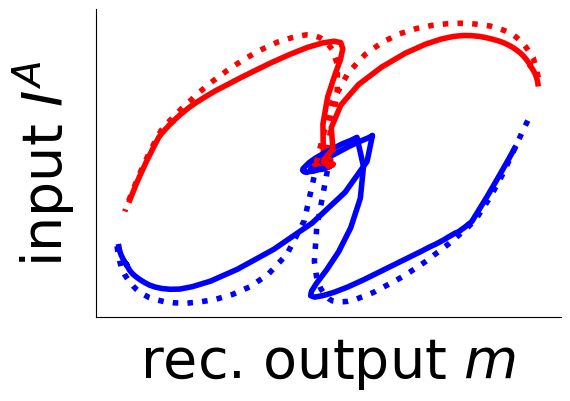

In [38]:
trials = [traj[(context == -1) & (choice > 0) & (motion > 0)],
          traj[(context == -1) & (choice > 0) & (motion < 0)],
          traj[(context == -1) & (choice < 0) & (motion > 0)],
          traj[(context == -1) & (choice < 0) & (motion < 0)]]
trials_other = [traj2[(context == -1) & (choice > 0) & (motion > 0)],
              traj2[(context == -1) & (choice > 0) & (motion < 0)],
              traj2[(context == -1) & (choice < 0) & (motion > 0)],
              traj2[(context == -1) & (choice < 0) & (motion < 0)]]
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(0), cmap(255), cmap(0), cmap(255)]


plot_projections(trials, -m, -wi1, colors, 'rec. output $m$', 'input $I^A$', trials_other)
plt.savefig('../figures/neurips/frfit_p4.pdf', bbox_inches='tight')

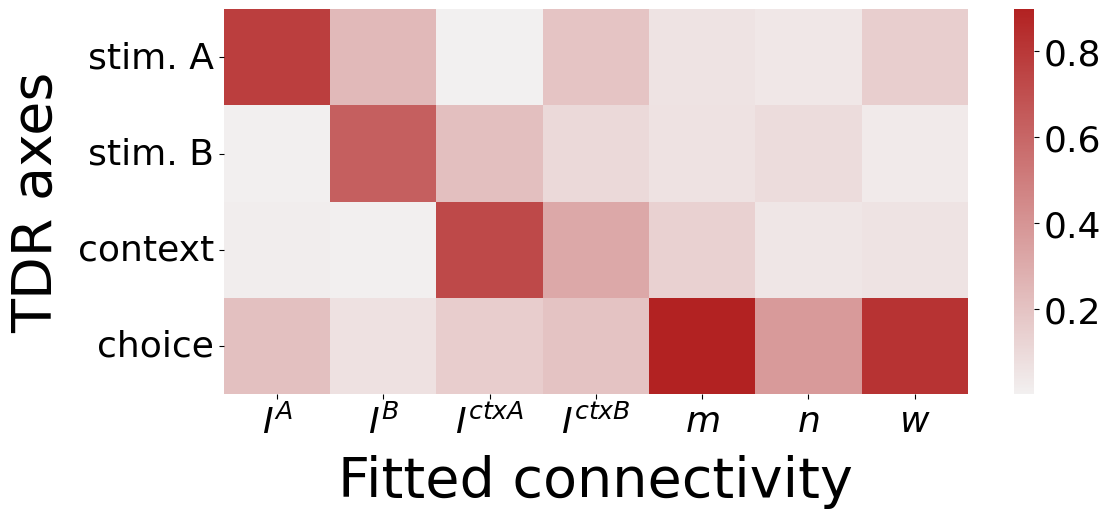

In [39]:
vecs_tdr = [beta_motion, beta_color, beta_context, beta_choice]
vecs_fit = [wi1, wi2, wi_ctx1, wi_ctx2, m, n, wo]

helpers.overlap_matrix2(vecs_tdr, vecs_fit, norm='l2', figsize=(12, 5), abs=True, cmap='abs')
plt.xlabel('Fitted connectivity')
plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 7, 1), ['$I^A$', '$I^B$', '$I^{ctxA}$', '$I^{ctxB}$', '$m$', '$n$', '$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['stim. A', 'stim. B', 'context', 'choice'], rotation='horizontal')
plt.savefig('../figures/neurips/frfit_mantematrix.pdf', bbox_inches='tight')
plt.show()

### Trajectories

In [40]:
labels = ['pp', 'np', 'pn', 'nn']

x1, _, _ = mante.generate_mante_data(1, context_spec=1, coh_color_spec=1, coh_motion_spec=1, fraction_validation_trials=0.)
x2, _, _ = mante.generate_mante_data(1, context_spec=1, coh_color_spec=-1, coh_motion_spec=1, fraction_validation_trials=0.)
x3, _, _ = mante.generate_mante_data(1, context_spec=1, coh_color_spec=1, coh_motion_spec=-1, fraction_validation_trials=0.)
x4, _, _ = mante.generate_mante_data(1, context_spec=1, coh_color_spec=-1, coh_motion_spec=-1, fraction_validation_trials=0.)
x = torch.cat([x1, x2, x3, x4], axis=0)

outp, traj = net1.forward(x, return_dynamics=True)
traj = traj.detach().numpy()

_, traj2 = net2.forward(x, return_dynamics=True)
traj2 = traj2.detach().numpy()

Text(0.5, 1.0, 'Context 1')

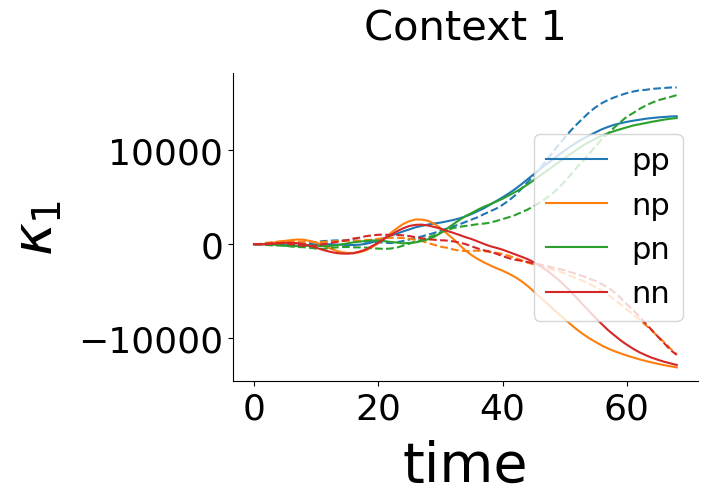

In [41]:
k1 = traj @ m
k1_2 = traj2 @ m

for i in range(4):
    p, = plt.plot(k1[i], label=labels[i])
    plt.plot(k1_2[i], ls='--', c=p.get_color())
plt.legend()
plt.xlabel('time')
plt.ylabel('$\kappa_1$')
plt.title('Context 1')

In [42]:
x1, _, _ = mante.generate_mante_data(1, context_spec=2, coh_color_spec=1, coh_motion_spec=1, fraction_validation_trials=0.)
x2, _, _ = mante.generate_mante_data(1, context_spec=2, coh_color_spec=-1, coh_motion_spec=1, fraction_validation_trials=0.)
x3, _, _ = mante.generate_mante_data(1, context_spec=2, coh_color_spec=1, coh_motion_spec=-1, fraction_validation_trials=0.)
x4, _, _ = mante.generate_mante_data(1, context_spec=2, coh_color_spec=-1, coh_motion_spec=-1, fraction_validation_trials=0.)
x = torch.cat([x1, x2, x3, x4], axis=0)

outp, traj = net1.forward(x, return_dynamics=True)
traj = traj.detach().numpy()

_, traj2 = net2.forward(x, return_dynamics=True)
traj2 = traj2.detach().numpy()

Text(0.5, 1.0, 'Context 2')

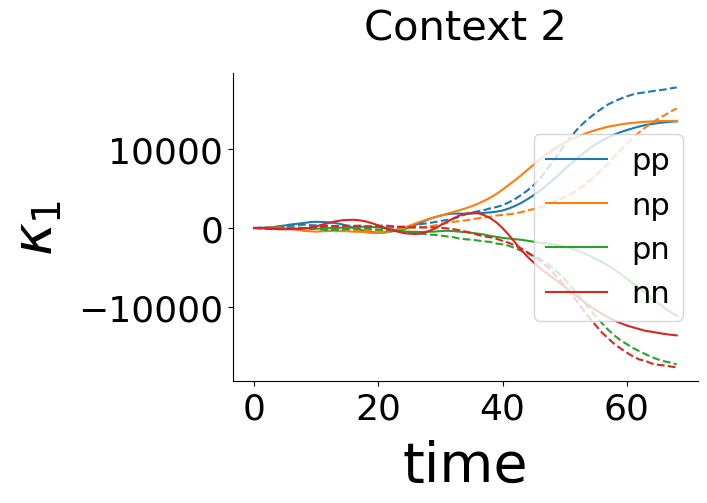

In [43]:
k1 = traj @ m
k1_2 = traj2 @ m

for i in range(4):
    p, = plt.plot(k1[i], label=labels[i])
    plt.plot(k1_2[i], ls='--', c=p.get_color())
plt.legend()
plt.xlabel('time')
plt.ylabel('$\kappa_1$')
plt.title('Context 2')

## Inactivations and gains

Inactivate hand-made populations on the low-rank network works

In [44]:
x_ctxA, y_ctxA, mask_ctxA = mante.generate_mante_data(100, fraction_validation_trials=0, context_spec=1)
x_ctxB, y_ctxB, mask_ctxB = mante.generate_mante_data(100, fraction_validation_trials=0, context_spec=2)


In [45]:
net_inac1 = clustering.inactivate_pop(net2, z==1)
net_inac2 = clustering.inactivate_pop(net2, z==2)
net_inac3 = clustering.inactivate_pop(net2, z==3)
net_inac0 = clustering.inactivate_pop(net2, z==0)

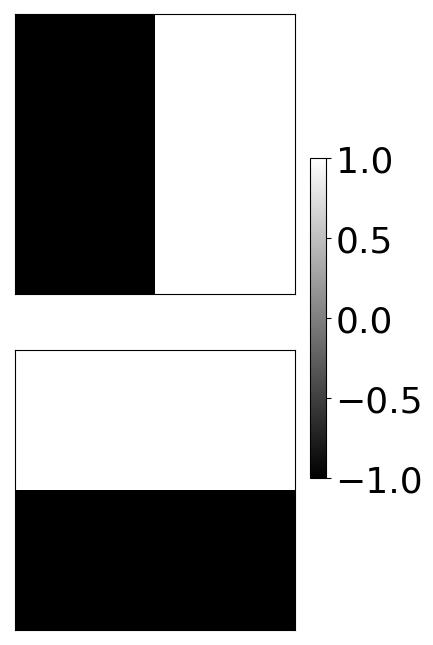

In [46]:
axes = mante.psychometric_matrices(net2, colorbar=True)
plt.savefig('../figures/neurips/mantefr_psycholr.pdf', bbox_inches='tight')

In [47]:
loss, acc_orig_lrA = mante.test_mante(net2, x_ctxA, y_ctxA, mask_ctxA)
print(acc_orig_lrA)
loss, acc_orig_lrB = mante.test_mante(net2, x_ctxB, y_ctxB, mask_ctxB)
print(acc_orig_lrB)

1.0
1.0


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

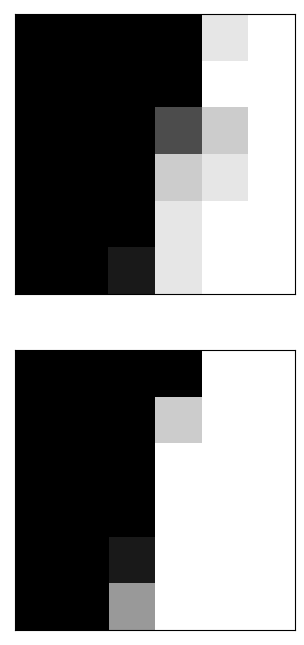

In [48]:
mante.psychometric_matrices(net_inac1)

In [49]:
loss, acc_inacB_lrA = mante.test_mante(net_inac1, x_ctxA, y_ctxA, mask_ctxA)
print(acc_inacB_lrA)
loss, acc_inacB_lrB = mante.test_mante(net_inac1, x_ctxB, y_ctxB, mask_ctxB)
print(acc_inacB_lrB)

0.9200000166893005
0.41999998688697815


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

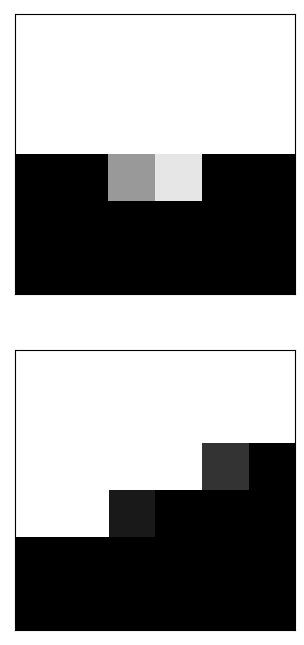

In [50]:
mante.psychometric_matrices(net_inac2)

In [51]:
loss, acc_inacA_lrA = mante.test_mante(net_inac2, x_ctxA, y_ctxA, mask_ctxA)
print(acc_inacA_lrA)
loss, acc_inacA_lrB = mante.test_mante(net_inac2, x_ctxB, y_ctxB, mask_ctxB)
print(acc_inacA_lrB)

0.5199999809265137
0.8600000143051147


In [52]:
plt.rcParams['axes.labelsize'] = 30

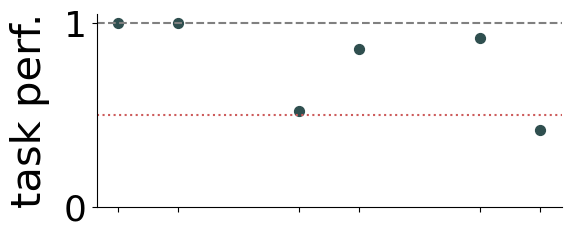

In [53]:
fig, ax = plt.subplots(figsize=(6, 2.5))
plt.scatter([1, 2, 4, 5, 7, 8], [acc_orig_lrA, acc_orig_lrB, acc_inacA_lrA, acc_inacA_lrB, acc_inacB_lrA, acc_inacB_lrB], c='darkslategray', s=50)
plt.ylim(0, 1.05)
plt.axhline(1, ls='--', color='gray')
plt.axhline(.5, ls='dotted', color='indianred')
plt.xticks([1, 2, 4, 5, 7, 8], [])
plt.ylabel('task perf.')
plt.savefig('../figures/neurips/inac_lr_perf.pdf', bbox_inches='tight')

Applying the same inactivations to the original full-rank network:

In [54]:
net_inac0 = clustering.inactivate_pop(net1, z==0)
net_inac1 = clustering.inactivate_pop(net1, z==1)
net_inac2 = clustering.inactivate_pop(net1, z==2)
# net_inac3 = clustering.inactivate_pop(net1, z==3)

In [55]:
loss, acc_orig_frA = mante.test_mante(net1, x_ctxA, y_ctxA, mask_ctxA)
print(acc_orig_frA)
loss, acc_orig_frB = mante.test_mante(net1, x_ctxB, y_ctxB, mask_ctxB)
print(acc_orig_frB)

1.0
1.0


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

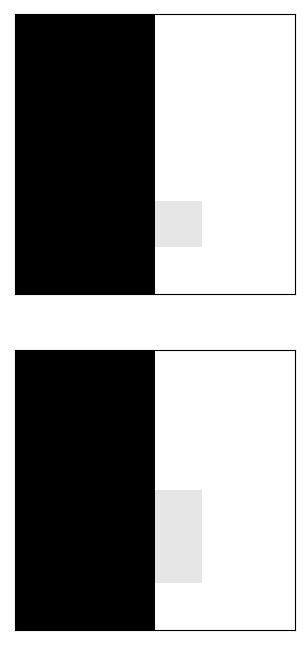

In [56]:
mante.psychometric_matrices(net_inac1)

In [57]:
loss, acc_inacB_frA = mante.test_mante(net_inac1, x_ctxA, y_ctxA, mask_ctxA)
print(acc_inacB_frA)
loss, acc_inacB_frB = mante.test_mante(net_inac1, x_ctxB, y_ctxB, mask_ctxB)
print(acc_inacB_frB)

1.0
0.49000000953674316


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

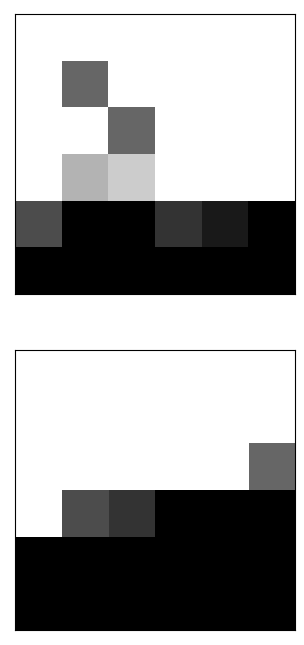

In [58]:
mante.psychometric_matrices(net_inac2)

In [59]:
loss, acc_inacA_frA = mante.test_mante(net_inac2, x_ctxA, y_ctxA, mask_ctxA)
print(acc_inacA_frA)
loss, acc_inacA_frB = mante.test_mante(net_inac2, x_ctxB, y_ctxB, mask_ctxB)
print(acc_inacA_frB)

0.6399999856948853
0.9300000071525574


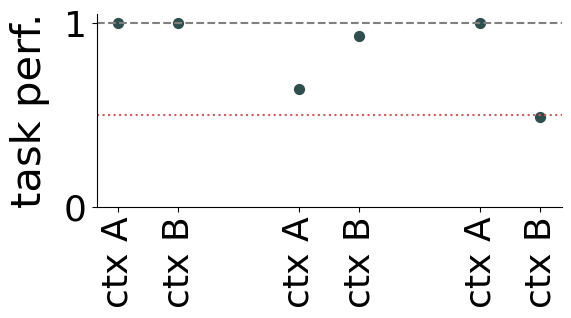

In [60]:
fig, ax = plt.subplots(figsize=(6, 2.5))
plt.scatter([1, 2, 4, 5, 7, 8], [acc_orig_frA, acc_orig_frB, acc_inacA_frA, acc_inacA_frB, acc_inacB_frA, acc_inacB_frB], c='darkslategray', s=50)
plt.ylim(0, 1.05)
plt.axhline(1, ls='--', color='gray')
plt.axhline(.5, ls='dotted', color='indianred')
plt.xticks([1, 2, 4, 5, 7, 8], ['ctx A', 'ctx B']*3, rotation=90)
plt.ylabel('task perf.')
plt.savefig('../figures/neurips/inac_fr_perf.pdf', bbox_inches='tight')

In [61]:
x_ctx1, _, _ = mante.generate_mante_data(50, context_spec=1, fraction_validation_trials=0)
_, traj1 = net1.forward(x_ctx1, return_dynamics=True)
traj1 = traj1.detach().numpy()
_, traj2 = net2.forward(x_ctx1, return_dynamics=True)
traj2 = traj2.detach().numpy()

x_ctx2, _, _ = mante.generate_mante_data(50, context_spec=2, fraction_validation_trials=0)
_, traj3 = net1.forward(x_ctx2, return_dynamics=True)
traj3 = traj3.detach().numpy()
_, traj4 = net2.forward(x_ctx2, return_dynamics=True)
traj4 = traj4.detach().numpy()

nlin_fr_c1 = np.tanh(traj1)[:, :mante.ctx_only_pre_duration].mean(axis=(0, 1))
nlin_lr_c1 = np.tanh(traj2)[:, :mante.ctx_only_pre_duration].mean(axis=(0, 1))
nlin_fr_c2 = np.tanh(traj3)[:, :mante.ctx_only_pre_duration].mean(axis=(0, 1))
nlin_lr_c2 = np.tanh(traj4)[:, :mante.ctx_only_pre_duration].mean(axis=(0, 1))

gains_fr_c1 = helpers.phi_prime(traj1)[:, :mante.ctx_only_pre_duration].mean(axis=(0, 1))
gains_lr_c1 = helpers.phi_prime(traj2)[:, :mante.ctx_only_pre_duration].mean(axis=(0, 1))
gains_fr_c2 = helpers.phi_prime(traj3)[:, :mante.ctx_only_pre_duration].mean(axis=(0, 1))
gains_lr_c2 = helpers.phi_prime(traj4)[:, :mante.ctx_only_pre_duration].mean(axis=(0, 1))

In [62]:
plt.rcParams['axes.labelsize'] = 35
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

In [70]:
colors = ['dimgray',  'seagreen', 'rebeccapurple']

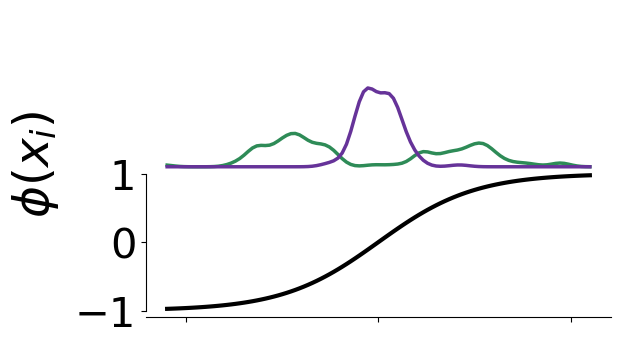

In [71]:
xs = np.linspace(-2.2, 2.2, 100)
ys = np.tanh(xs)

kde1 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(traj2[:, :mante.ctx_only_pre_duration, z==1].mean(axis=(0,1)).reshape((-1, 1)))
ys1 = np.exp(kde1.score_samples(xs.reshape((-1, 1))))
ys1 = ys1 / np.sum(ys1) * 15

kde2 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(traj2[:, :mante.ctx_only_pre_duration, z==2].mean(axis=(0,1)).reshape((-1, 1)))
ys2 = np.exp(kde2.score_samples(xs.reshape((-1, 1))))
ys2 = ys2 / np.sum(ys2) * 15

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(xs, ys, c='k', lw=3)
ax.plot(xs, ys1 + 1.1, c=colors[1], lw=2.5)
ax.plot(xs, ys2 + 1.1, c=colors[2], lw=2.5)
ax.set_ylim(-1.1, 3.4)
ax.axes.spines['left'].set_bounds([-1, 1])
ax.set_yticks([-1, 0, 1])
ax.set_xticklabels([])
# ax.set_xlabel('$x_i$')
ax.set_ylabel('$\phi(x_i)$', position=(0,.3))
plt.savefig('../figures/neurips/gains1.pdf', bbox_inches='tight')

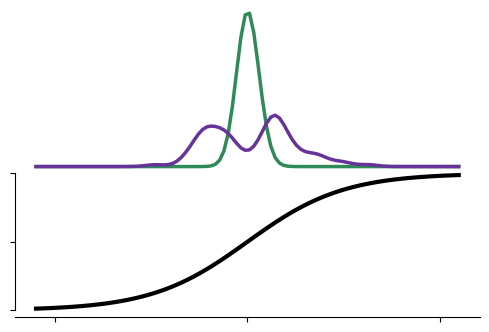

In [72]:
xs = np.linspace(-2.2, 2.2, 100)
ys = np.tanh(xs)

kde1 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(traj4[:, :mante.ctx_only_pre_duration, z==1].mean(axis=(0,1)).reshape((-1, 1)))
ys1 = np.exp(kde1.score_samples(xs.reshape((-1, 1))))
ys1 = ys1 / np.sum(ys1) * 15

kde2 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(traj4[:, :mante.ctx_only_pre_duration, z==2].mean(axis=(0,1)).reshape((-1, 1)))
ys2 = np.exp(kde2.score_samples(xs.reshape((-1, 1))))
ys2 = ys2 / np.sum(ys2) * 15

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(xs, ys, c='k', lw=3)
ax.plot(xs, ys1 + 1.1, c=colors[1], lw=2.5)
ax.plot(xs, ys2 + 1.1, c=colors[2], lw=2.5)
ax.set_ylim(-1.1, 3.4)
ax.axes.spines['left'].set_bounds([-1, 1])
ax.set_yticks([-1, 0, 1])
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xlabel('$x_i$')
# ax.set_ylabel('$\phi(x_i)$', position=(0,.3))
plt.savefig('../figures/neurips/gains2.pdf', bbox_inches='tight')

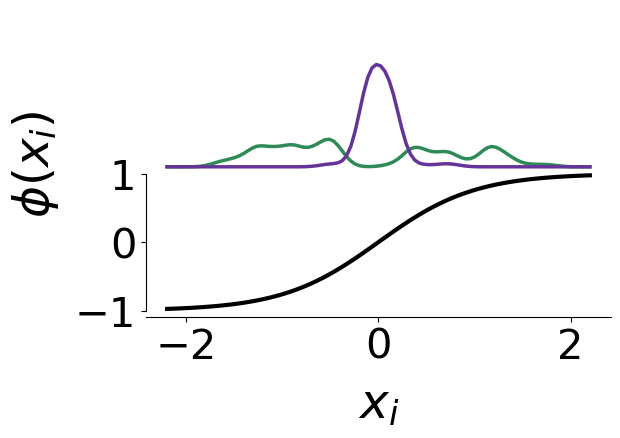

In [73]:
xs = np.linspace(-2.2, 2.2, 100)
ys = np.tanh(xs)

kde1 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(traj1[:, :mante.ctx_only_pre_duration, z==1].mean(axis=(0,1)).reshape((-1, 1)))
ys1 = np.exp(kde1.score_samples(xs.reshape((-1, 1))))
ys1 = ys1 / np.sum(ys1) * 15

kde2 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(traj1[:, :mante.ctx_only_pre_duration, z==2].mean(axis=(0,1)).reshape((-1, 1)))
ys2 = np.exp(kde2.score_samples(xs.reshape((-1, 1))))
ys2 = ys2 / np.sum(ys2) * 15

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(xs, ys, c='k', lw=3)
ax.plot(xs, ys1 + 1.1, c=colors[1], lw=2.5)
ax.plot(xs, ys2 + 1.1, c=colors[2], lw=2.5)
ax.set_ylim(-1.1, 3.4)
ax.axes.spines['left'].set_bounds([-1, 1])
ax.set_yticks([-1, 0, 1])
ax.set_xlabel('$x_i$')
ax.set_ylabel('$\phi(x_i)$', position=(0,.3))
plt.savefig('../figures/neurips/gains_sup1.pdf', bbox_inches='tight')

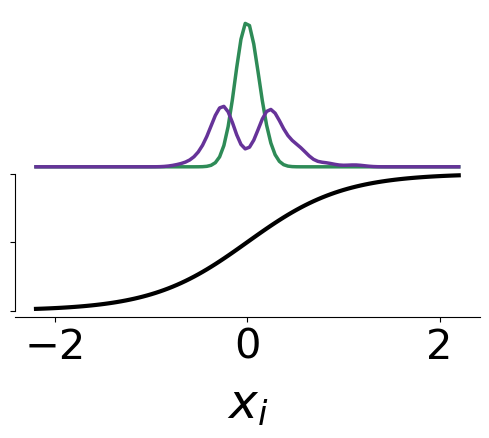

In [74]:
xs = np.linspace(-2.2, 2.2, 100)
ys = np.tanh(xs)

kde1 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(traj3[:, :mante.ctx_only_pre_duration, z==1].mean(axis=(0,1)).reshape((-1, 1)))
ys1 = np.exp(kde1.score_samples(xs.reshape((-1, 1))))
ys1 = ys1 / np.sum(ys1) * 15

kde2 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(traj3[:, :mante.ctx_only_pre_duration, z==2].mean(axis=(0,1)).reshape((-1, 1)))
ys2 = np.exp(kde2.score_samples(xs.reshape((-1, 1))))
ys2 = ys2 / np.sum(ys2) * 15

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(xs, ys, c='k', lw=3)
ax.plot(xs, ys1 + 1.1, c=colors[1], lw=2.5)
ax.plot(xs, ys2 + 1.1, c=colors[2], lw=2.5)
ax.set_ylim(-1.1, 3.4)
ax.axes.spines['left'].set_bounds([-1, 1])
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels([])
ax.set_xlabel('$x_i$')
# ax.set_ylabel('$\phi(x_i)$', position=(0,.3))
plt.savefig('../figures/neurips/gains_sup2.pdf', bbox_inches='tight')